In [ ]:
from google.colab import drive                                                    # Mounting Google Drive
drive.mount('/content/drive')
path="/content/drive/MyDrive/data/dream.txt"
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

""""""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));
""""""

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive'):
    for filename in filenames:
      print(os.path.join(dirname, filename));

In [ ]:
path

'/content/drive/MyDrive/data/dream.txt'

In [ ]:
data1 = pd.read_csv(path, sep=',', header=0, names=["Movie","User","Rating","Date"])
data1.head()
#df = pd.read_csv("gfg.txt", sep=" ", header=None,names=["Team1", "Team2"])

,Movie,User,Rating,Date
0,1,822109,5,2005-05-13
1,1,885013,4,2005-10-19
2,1,30878,4,2005-12-26
3,1,823519,3,2004-05-03
4,1,893988,3,2005-11-17


In [ ]:
data11=data1

In [ ]:
data11.describe()

,Movie,User,Rating
count,2.405376e+07,2.405376e+07,2.405376e+07
mean,2.308324e+03,1.322285e+06,3.599634e+00
std,1.303909e+03,7.645780e+05,1.086118e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,1.180000e+03,6.609270e+05,3.000000e+00
50%,2.342000e+03,1.318602e+06,4.000000e+00
75%,3.433000e+03,1.984358e+06,4.000000e+00
max,4.499000e+03,2.649429e+06,5.000000e+00


In [ ]:
data2=data11
group = data2.groupby('User')['Rating'].count()
top_users = group.sort_values(ascending=False)[:1000]

group = data2.groupby('Movie')['Rating'].count()
top_movies = group.sort_values(ascending=False)[:200]
top_movies

Movie
1905    193941
2152    162597
3860    160454
4432    156183
571     154832
         ...  
4080     31372
2734     31058
4389     30958
896      30593
4384     30580
Name: Rating, Length: 200, dtype: int64

In [ ]:
data22 = data2.join(top_users, rsuffix='_r', how='inner', on='User')
data22 = data22.join(top_movies, rsuffix='_r', how='inner', on='Movie')
# Re-name the users and movies for uniform name from 0..2000 and 10000
user_encoded = LabelEncoder()
data22['Usern'] = user_encoded.fit_transform(data22['User'].values)
movie_encoded = LabelEncoder()
data22['Movien'] = movie_encoded.fit_transform(data22['Movie'].values)

n_movies = data22['Movien'].nunique()
n_users = data22['Usern'].nunique()

print(n_movies, n_users)
data22

200 1000


,Movie,User,Rating,Date,Rating_r,Rating_r,Usern,Movien
54489,28,1181550,5,2003-07-26,629,39752,467,0
54506,28,1227322,2,2003-09-28,1177,39752,488,0
55537,28,1009622,3,2004-08-16,531,39752,392,0
57155,28,716874,5,2005-03-04,835,39752,276,0
57793,28,883478,4,2005-01-09,793,39752,342,0
...,...,...,...,...,...,...,...,...
5159383,1046,194528,2,2005-07-28,537,40744,71,41
5161037,1046,1528604,2,2004-06-21,665,40744,594,41
5162124,1046,360005,3,2004-12-18,514,40744,142,41
5173859,1046,1867238,3,2004-01-18,577,40744,714,41


In [ ]:
data22.describe()

,Movie,User,Rating,Rating_r,Rating_r,Usern,Movien
count,151602.000000,1.516020e+05,151602.000000,151602.000000,151602.000000,151602.000000,151602.000000
mean,2345.195875,1.300969e+06,3.514182,722.839059,71401.550105,498.717213,99.878181
std,1324.554164,7.679880e+05,1.117753,383.860485,36411.667410,289.178295,57.415476
min,28.000000,1.333000e+03,1.000000,513.000000,30580.000000,0.000000,0.000000
25%,1220.000000,6.372660e+05,3.000000,551.000000,41355.000000,249.000000,51.000000
50%,2342.000000,1.262753e+06,4.000000,617.000000,59137.000000,499.000000,99.000000
75%,3605.000000,1.984315e+06,4.000000,738.000000,93241.000000,750.000000,150.000000
max,4488.000000,2.645579e+06,5.000000,4467.000000,193941.000000,999.000000,199.000000


In [ ]:
# can use data22 = pd.read_csv('top_data.csv') for all movies from original dataset
# also includes above grouping/sorting and encoding
# but will need to change cells above: n_movies = data22['movie'].nunique(), n_users = data22['user'].nunique()
#   and below: X = data22['Usern','Movien'].values to X = data22['user', 'movie'].values

In [ ]:
X = data22[['Usern', 'Movien']].values
y = data22['Rating'].values

# Split train and test data (for test model performance at last)
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

# Set the embedding dimension d of Matrix factorization
e_dimension = 200 # was 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
# Build user and movie embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
u = Reshape((e_dimension,))(u)
movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
## new : concat user, id along with dot
x = Concatenate()([u, m,x])
x = Dropout(0.2)(x)

# Build last deep learning layers 
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(1)(x)
model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.003),  ## 0.001
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  
history = model.fit(x=X_train_array, y=y_train, batch_size=64,
                    epochs=10, # 20
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       200000      ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       40000       ['input_6[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Trainable params: 343,169
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
1919/1919 [==============================] - 18s 8ms/step - loss: 1.1181 - root_mean_squared_error: 1.0573 - val_loss: 0.9088 - val_root_mean_squared_error: 0.9532
Epoch 2/10
1919/1919 [==============================] - 14s 7ms/step - loss: 0.9134 - root_mean_squared_error: 0.9556 - val_loss: 0.8668 - val_root_mean_squared_error: 0.9308
Epoch 3/10
1919/1919 [==============================] - 14s 7ms/step - loss: 0.8633 - root_mean_squared_error: 0.9288 - val_loss: 0.8393 - val_root_mean_squared_error: 0.9158
Epoch 4/10
1919/1919 [==============================] - 14s 7ms/step - loss: 0.7886 - root_mean_squared_error: 0.8876 - val_loss: 0.8242 - val_root_mean_squared_error: 0.9073
Epoch 5/10
1919/1919 [==============================] - 12s 6ms/step - loss: 0.6502 - root_mean_squared_error: 0.8056 - val_loss: 0.8279 - val_root_mea

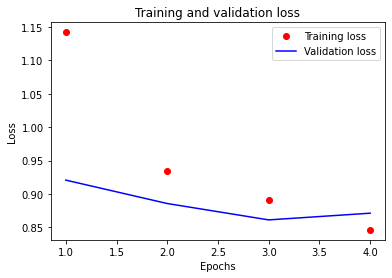

In [ ]:
# Visualize the training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

0.920534

In [ ]:
lite_rating_df1 = pd.DataFrame()

group1 = data11.groupby('User')['Rating'].count()
top_userss = group1.sort_values(ascending=False)[:1000]

group2 = data11.groupby('Movie')['Rating'].count()
top_moviess = group2.sort_values(ascending=False)[:200]

lite_rating_df1 = data11.join(top_userss, rsuffix='_ur', how='inner', on='User')
lite_rating_df = lite_rating_df.join(top_moviess, rsuffix='_mr', how='inner', on='Movie')

# Re-name the users and movies for uniform name from 0..2000 and 10000
user_encc = LabelEncoder()
lite_rating_df['Usern'] = user_encc.fit_transform(lite_rating_df['User'].values)
movie_encc = LabelEncoder()
lite_rating_df['Movien'] = movie_encc.fit_transform(lite_rating_df['Movie'].values)

n_movies = lite_rating_df['Movien'].nunique()
n_users = lite_rating_df['Usern'].nunique()

print(n_movies, n_users)
lite_rating_df
#movie_id	user_id	

200 1000


,Movie,User,Rating,Date,Rating_ur,Rating_mr,Usern,Movien,Rating_mr,Rating_mr,Rating_mr
54489,28,1181550,5,2003-07-26,629,39752,467,0,39752,39752,39752
54506,28,1227322,2,2003-09-28,1177,39752,488,0,39752,39752,39752
55537,28,1009622,3,2004-08-16,531,39752,392,0,39752,39752,39752
57155,28,716874,5,2005-03-04,835,39752,276,0,39752,39752,39752
57793,28,883478,4,2005-01-09,793,39752,342,0,39752,39752,39752
...,...,...,...,...,...,...,...,...,...,...,...
5159383,1046,194528,2,2005-07-28,537,40744,71,41,40744,40744,40744
5161037,1046,1528604,2,2004-06-21,665,40744,594,41,40744,40744,40744
5162124,1046,360005,3,2004-12-18,514,40744,142,41,40744,40744,40744
5173859,1046,1867238,3,2004-01-18,577,40744,714,41,40744,40744,40744


In [ ]:
lite_rating_df.describe()

,Movie,User,Rating,Rating_ur,Rating_mr,Usern,Movien,Rating_mr,Rating_mr
count,151602.000000,1.516020e+05,151602.000000,151602.000000,151602.000000,151602.000000,151602.000000,151602.000000,151602.000000
mean,2345.195875,1.300969e+06,3.514182,722.839059,71401.550105,498.717213,99.878181,71401.550105,71401.550105
std,1324.554164,7.679880e+05,1.117753,383.860485,36411.667410,289.178295,57.415476,36411.667410,36411.667410
min,28.000000,1.333000e+03,1.000000,513.000000,30580.000000,0.000000,0.000000,30580.000000,30580.000000
25%,1220.000000,6.372660e+05,3.000000,551.000000,41355.000000,249.000000,51.000000,41355.000000,41355.000000
50%,2342.000000,1.262753e+06,4.000000,617.000000,59137.000000,499.000000,99.000000,59137.000000,59137.000000
75%,3605.000000,1.984315e+06,4.000000,738.000000,93241.000000,750.000000,150.000000,93241.000000,93241.000000
max,4488.000000,2.645579e+06,5.000000,4467.000000,193941.000000,999.000000,199.000000,193941.000000,193941.000000


In [ ]:
counts = (lite_rating_df['Usern'] == 0).sum()
print(counts)
for column_name in lite_rating_df.columns:
    column = lite_rating_df[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

165
Count of zeros in column  Movie  is :  0
Count of zeros in column  User  is :  0
Count of zeros in column  Rating  is :  0
Count of zeros in column  Date  is :  0
Count of zeros in column  Rating_ur  is :  0
Count of zeros in column  Rating_mr  is :  Rating_mr    0
Rating_mr    0
Rating_mr    0
dtype: int64
Count of zeros in column  Usern  is :  165
Count of zeros in column  Movien  is :  675
Count of zeros in column  Rating_mr  is :  Rating_mr    0
Rating_mr    0
Rating_mr    0
dtype: int64
Count of zeros in column  Rating_mr  is :  Rating_mr    0
Rating_mr    0
Rating_mr    0
dtype: int64


In [ ]:
data3 = data2.join(top_users, lsuffix='_l', rsuffix='_r', how='inner', on='User')
data3 = data3.join(top_movies, lsuffix='_l', rsuffix='_r', how='inner', on='Movie')
data3
data3.describe()

,Movie,User,Rating_l,Rating_r,Rating
count,151602.000000,1.516020e+05,151602.000000,151602.000000,151602.000000
mean,2345.195875,1.300969e+06,3.514182,722.839059,71401.550105
std,1324.554164,7.679880e+05,1.117753,383.860485,36411.667410
min,28.000000,1.333000e+03,1.000000,513.000000,30580.000000
25%,1220.000000,6.372660e+05,3.000000,551.000000,41355.000000
50%,2342.000000,1.262753e+06,4.000000,617.000000,59137.000000
75%,3605.000000,1.984315e+06,4.000000,738.000000,93241.000000
max,4488.000000,2.645579e+06,5.000000,4467.000000,193941.000000


In [ ]:
# Re-name the users and movies for uniform name from 0..2000 and 10000
User_enc = LabelEncoder()
data3['nUser'] = User_enc.fit_transform(data3['User'].values)
Movie_enc = LabelEncoder()
data3['nMovie'] = Movie_enc.fit_transform(data3['Movie'].values)

no_of_movies = data3['nMovie'].nunique()
no_of_users = data3['nUser'].nunique()

print(no_of_movies, no_of_users)
data3

200 1000


,Movie,User,Rating_l,Date,Rating_r,Rating,nUser,nMovie
54489,28,1181550,5,2003-07-26,629,39752,467,0
54506,28,1227322,2,2003-09-28,1177,39752,488,0
55537,28,1009622,3,2004-08-16,531,39752,392,0
57155,28,716874,5,2005-03-04,835,39752,276,0
57793,28,883478,4,2005-01-09,793,39752,342,0
...,...,...,...,...,...,...,...,...
5159383,1046,194528,2,2005-07-28,537,40744,71,41
5161037,1046,1528604,2,2004-06-21,665,40744,594,41
5162124,1046,360005,3,2004-12-18,514,40744,142,41
5173859,1046,1867238,3,2004-01-18,577,40744,714,41


In [ ]:
data1=data1.sort_values(by='Date')
data1

,Movie,User,Rating,Date
6901472,1367,510180,5,1999-11-11
9056170,1798,510180,5,1999-11-11
20393917,3870,510180,2,1999-11-11
14892676,2866,510180,3,1999-11-11
19585851,3730,510180,4,1999-11-11
...,...,...,...,...
15765006,3079,1126446,5,2005-12-31
20667141,3917,416053,4,2005-12-31
15137015,2913,59069,4,2005-12-31
22682771,4302,2566993,4,2005-12-31


In [ ]:
print(data1.nunique())
data1

Movie       4499
User      470758
Rating         5
Date        2182
dtype: int64


,Movie,User,Rating,Date
6901472,1367,510180,5,1999-11-11
9056170,1798,510180,5,1999-11-11
20393917,3870,510180,2,1999-11-11
14892676,2866,510180,3,1999-11-11
19585851,3730,510180,4,1999-11-11
...,...,...,...,...
15765006,3079,1126446,5,2005-12-31
20667141,3917,416053,4,2005-12-31
15137015,2913,59069,4,2005-12-31
22682771,4302,2566993,4,2005-12-31


In [ ]:
data2=data1
lite_rating_df = pd.DataFrame()
lite_rating_df 
data3=data2[:200000]

In [ ]:
group = data2.groupby('User')['Rating'].count()
top_users = group.sort_values(ascending=False)[:10000]

group = data2.groupby('Movie')['Rating'].count()
top_movies = group.sort_values(ascending=False)[:2000]

In [ ]:
data3

,Movie,User,Rating,Date
6901472,1367,510180,5,1999-11-11
9056170,1798,510180,5,1999-11-11
20393917,3870,510180,2,1999-11-11
14892676,2866,510180,3,1999-11-11
19585851,3730,510180,4,1999-11-11
...,...,...,...,...
1370572,295,1465791,1,2001-01-06
1522086,312,131133,4,2001-01-06
18671038,3581,1912283,4,2001-01-06
21868351,4123,361393,3,2001-01-06
